### Importing Needed packages


In [55]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.utils.data import TensorDataset

### Downloading Data

In [56]:
# !wget -O books2.csv https://raw.githubusercontent.com/heEXDe/some_machine_learning_jupyter_notebooks/main/books2.csv

<h2 id="reading_data">Reading the data in</h2>


In [57]:
df = pd.read_csv("books2.csv", encoding="utf-8-sig")
df.head(9)

,Unnamed: 0,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,0,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,1,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,2,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,3,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,4,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic
5,5,"Unauthorized Harry Potter Book Seven News: ""Ha...",W. Frederick Zimmerman,3.74,976540606,9780976540601,eng,152,19,1,4/26/2005,Nimble Books
6,6,Harry Potter Collection (Harry Potter #1-6),J.K. Rowling,4.73,439827604,9780439827607,eng,3342,28242,808,9/12/2005,Scholastic
7,7,The Ultimate Hitchhiker's Guide: Five Complete...,Douglas Adams,4.38,517226952,9780517226957,eng,815,3628,254,11/1/2005,Gramercy Books
8,8,The Ultimate Hitchhiker's Guide to the Galaxy ...,Douglas Adams,4.38,345453743,9780345453747,eng,815,249558,4080,4/30/2002,Del Rey Books


As we will be trying to develop a model to predict the average ratings scores for books, and because those scores can have non-integer values, our dependent values will be of the continuous nature.
Lets select some features that we want to use for regression.

In [58]:
cdf = df[['num_pages', 'ratings_count', 'text_reviews_count', 'average_rating']]
# print(len(cdf))
cdf.head(10)

,num_pages,ratings_count,text_reviews_count,average_rating
0,652,2095690,27591,4.57
1,870,2153167,29221,4.49
2,352,6333,244,4.42
3,435,2339585,36325,4.56
4,2690,41428,164,4.78
5,152,19,1,3.74
6,3342,28242,808,4.73
7,815,3628,254,4.38
8,815,249558,4080,4.38
9,215,4930,460,4.22


Lets we check if there is a linear correlationn between the independent and dependent daata - 'num_pages' and 'average_rating', 'ratings_count' and 'average_rating', 'text_reviews_count' and 'average_rating':


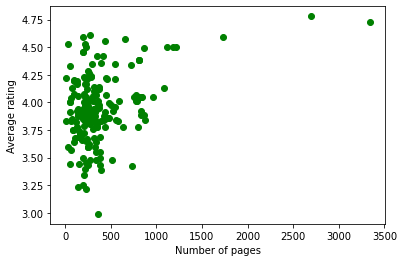

In [59]:
plt.scatter(cdf.num_pages, cdf.average_rating,  color='green')
plt.xlabel("Number of pages")
plt.ylabel("Average rating")
plt.show()

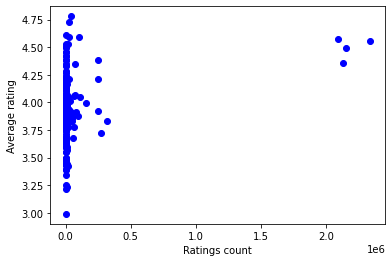

In [60]:
plt.scatter(cdf.ratings_count, cdf.average_rating,  color='blue')
plt.xlabel("Ratings count")
plt.ylabel("Average rating")
plt.show()

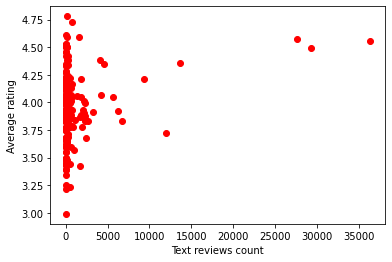

In [61]:
plt.scatter(cdf.text_reviews_count, cdf.average_rating,  color='red')
plt.xlabel("Text reviews count")
plt.ylabel("Average rating")
plt.show()

Splitting data into 'features' set and 'targets' set and setting the sizes of the train, test and evaluation sets.

In [62]:
features = cdf.drop(['average_rating'], axis = 1)
targets = cdf.iloc[:, -1]
train_size = int(math.ceil(.8 * len(cdf))) # 80% of dataset for training; '-1' because of teh use of the 'ceil' method below
val_size = int(math.ceil(.1 * len(cdf)))  # 10% for validation
test_size = int(math.floor((.1 * len(cdf)))) # 10% for testing

Spliting data according to the sizes.

In [63]:
dataset = TensorDataset(torch.Tensor(np.array(features)).float(), torch.Tensor(targets).long()) # numpy arrays to torch tensors
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

Setting the batch size and preparing data loaders.

In [64]:
batch_size = 100
train_loader = DataLoader(train_ds, batch_size, shuffle = True)
val_loader = DataLoader(val_ds, batch_size, shuffle = True)
test_loader = DataLoader(test_ds, batch_size, shuffle = True)

In [65]:
input_size = len(cdf.columns) - 1
# print(input_size)
output_size = len(targets.unique())
# print(output_size)
# threshold = .5

Declaring the model calss.

In [66]:
class BooksModel(nn.Module):

    def __init__(self, in_size, out_size):
        super().__init__()
        self.linear1 = nn.Linear(in_size, 80)
        self.linear2 = nn.Linear(80, 150)
        self.linear3 = nn.Linear(150, out_size)

    def forward(self, xb):
        out = self.linear1(xb)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        return out

Model initiation.

In [67]:
model = BooksModel(input_size, output_size)

Training. First - calculating number of epochs.

In [68]:
n_iters = 500
num_epochs = n_iters / (len(train_ds) / batch_size)
num_epochs = int(num_epochs)
print(len(train_ds))
print('num_epochs:', num_epochs)

160
num_epochs: 312


In [69]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

Process of training:

In [70]:
for epoch in range(num_epochs):
    for i, (x, y) in enumerate(train_loader):
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    for z, (r, w) in enumerate(val_loader):
        outputs = model(r)
        loss = criterion(outputs, w)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

In [71]:
def predict(features, model):
  with torch.no_grad():
    y_pred = model(features)
    y_pred = F.softmax(y_pred.unsqueeze(0), dim=1)
    print(y_pred)
    _, preds = torch.max(y_pred, 1)
    print(preds)
    return preds[0]

In [72]:
x, y = dataset[3]
print('act_val: {}, pred: {}'.format(y, predict(x, model)))
print(x)

tensor([[6.0910e-05, 3.9523e-05, 1.6317e-03, 4.8841e-01, 5.0588e-01, 4.9145e-05,
         4.2462e-05, 4.7458e-05, 5.7020e-05, 3.8152e-05, 6.2123e-06, 4.4884e-05,
         5.7801e-05, 4.2298e-05, 4.6770e-05, 4.6955e-05, 4.8794e-05, 4.5167e-05,
         4.7658e-05, 1.5878e-05, 5.3582e-05, 5.8025e-05, 4.1697e-05, 4.2878e-05,
         4.5398e-05, 4.5372e-05, 4.2052e-05, 4.5244e-05, 5.2726e-05, 4.8101e-05,
         4.8238e-05, 6.1400e-05, 4.8599e-05, 5.6308e-05, 4.3937e-05, 5.5851e-05,
         5.8240e-05, 5.6751e-05, 5.8539e-05, 4.9627e-05, 5.7828e-06, 4.9207e-05,
         5.8226e-05, 5.9472e-05, 5.2637e-05, 3.1890e-05, 4.6616e-05, 4.2094e-05,
         4.6477e-05, 6.2519e-05, 5.5169e-05, 4.8406e-05, 4.6498e-05, 5.8242e-05,
         4.0607e-05, 4.1372e-05, 5.8301e-05, 4.8596e-05, 4.6535e-05, 5.6433e-05,
         4.3691e-05, 4.5579e-05, 4.4852e-05, 3.8702e-05, 3.9971e-05, 5.5786e-05,
         4.9072e-05, 4.4614e-05, 4.7221e-05, 3.5818e-05, 5.8004e-05, 4.2001e-05,
         5.1232e-05, 4.5531e